In [2]:
#!/usr/bin/env python3
# Copyright (c) Meta Platforms, Inc. and affiliates.

import os
import sys
sys.path.append('../')
import argparse
import numpy as np
from tqdm import tqdm
import re
import datetime
import PIL
import PIL.Image as Image
import torch
import torch.nn.functional as F
from torchvision import transforms
from pycocotools import mask
import pycocotools.mask as mask_util
from scipy import ndimage
from scipy.linalg import eigh
import json

import dino
# modfied by Xudong Wang based on third_party/TokenCut
import utils, metric
# bilateral_solver codes are modfied based on https://github.com/poolio/bilateral_solver/blob/master/notebooks/bilateral_solver.ipynb
# from TokenCut.unsupervised_saliency_detection.bilateral_solver import BilateralSolver, BilateralGrid
# crf codes are are modfied based on https://github.com/lucasb-eyer/pydensecrf/blob/master/pydensecrf/tests/test_dcrf.py
from crf import densecrf

In [3]:
def detect_box(bipartition, seed,  dims, initial_im_size=None, scales=None, principle_object=True):
    """
    Extract a box corresponding to the seed patch. Among connected components extract from the affinity matrix, select the one corresponding to the seed patch.
    """
    w_featmap, h_featmap = dims
    objects, num_objects = ndimage.label(bipartition)
    cc = objects[np.unravel_index(seed, dims)]


    if principle_object:
        mask = np.where(objects == cc)
       # Add +1 because excluded max
        ymin, ymax = min(mask[0]), max(mask[0]) + 1
        xmin, xmax = min(mask[1]), max(mask[1]) + 1
        # Rescale to image size
        r_xmin, r_xmax = scales[1] * xmin, scales[1] * xmax
        r_ymin, r_ymax = scales[0] * ymin, scales[0] * ymax
        pred = [r_xmin, r_ymin, r_xmax, r_ymax]

        # Check not out of image size (used when padding)
        if initial_im_size:
            pred[2] = min(pred[2], initial_im_size[1])
            pred[3] = min(pred[3], initial_im_size[0])

        # Coordinate predictions for the feature space
        # Axis different then in image space
        pred_feats = [ymin, xmin, ymax, xmax]

        return pred, pred_feats, objects, mask
    else:
        raise NotImplementedError

In [4]:
# Image transformation applied to all images
ToTensor = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(
                                (0.485, 0.456, 0.406),
                                (0.229, 0.224, 0.225)),])

def get_affinity_matrix(feats, tau, eps=1e-5):
    # get affinity matrix via measuring patch-wise cosine similarity
    feats = F.normalize(feats, p=2, dim=0)
    A = (feats.transpose(0,1) @ feats).cpu().numpy()
    # convert the affinity matrix to a binary one.
    A = A > tau
    A = np.where(A.astype(float) == 0, eps, A)
    d_i = np.sum(A, axis=1)
    D = np.diag(d_i)
    return A, D

def second_smallest_eigenvector(A, D):
    # get the second smallest eigenvector from affinity matrix
    _, eigenvectors = eigh(D-A, D, subset_by_index=[1,2])
    eigenvec = np.copy(eigenvectors[:, 0])
    second_smallest_vec = eigenvectors[:, 0]
    return eigenvec, second_smallest_vec

def get_salient_areas(second_smallest_vec):
    # get the area corresponding to salient objects.
    avg = np.sum(second_smallest_vec) / len(second_smallest_vec)
    bipartition = second_smallest_vec > avg
    return bipartition

def check_num_fg_corners(bipartition, dims):
    # check number of corners belonging to the foreground
    bipartition_ = bipartition.reshape(dims)
    top_l, top_r, bottom_l, bottom_r = bipartition_[0][0], bipartition_[0][-1], bipartition_[-1][0], bipartition_[-1][-1]
    nc = int(top_l) + int(top_r) + int(bottom_l) + int(bottom_r)
    return nc

def get_masked_affinity_matrix(painting, feats, mask, ps):
    # mask out affinity matrix based on the painting matrix 
    dim, num_patch = feats.size()[0], feats.size()[1]
    painting = painting + mask.unsqueeze(0)
    painting[painting > 0] = 1
    painting[painting <= 0] = 0
    feats = feats.clone().view(dim, ps, ps)
    feats = ((1 - painting) * feats).view(dim, num_patch)
    return feats, painting



In [5]:
def get_tokencut_binary_map(img_pth, backbone,patch_size, attn = 'self') :
    I = Image.open(img_pth).convert('RGB')
    #print('original image size: ', I.size)
    I_resize, w, h, feat_w, feat_h = utils.resize_pil(I, patch_size)
    #print(I_resize, w, h, feat_w, feat_h)
    tensor = ToTensor(I_resize).unsqueeze(0).cuda()#.half()
    #attn = backbone(tensor)[0]
    if attn =='self':
        attn = backbone.model.get_all_selfattention(tensor)
    else:
        #print('get temp attention')
        attn = backbone.model.get_all_tempattention(tensor)
    #attn = backbone.model.get_intermediate_layers(tensor,12)

    return attn,w, h, feat_w, feat_h

In [6]:
def maskcut_forward(feats, dims, scales, init_image_size, tau=0, N=3, cpu=False):
    """
    Implementation of MaskCut.
    Inputs
      feats: the pixel/patche features of an image
      dims: dimension of the map from which the features are used
      scales: from image to map scale
      init_image_size: size of the image
      tau: thresold for graph construction
      N: number of pseudo-masks per image.
    """
    bipartitions = []
    eigvecs = []

    for i in range(N):
        if i == 0:
            painting = torch.from_numpy(np.zeros(dims))
            if not cpu: painting = painting.cuda()
        else:
            feats, painting = get_masked_affinity_matrix(painting, feats, current_mask, ps)
            print(painting)
        # construct the affinity matrix
        A, D = get_affinity_matrix(feats, tau)
        # get the second smallest eigenvector
        eigenvec, second_smallest_vec = second_smallest_eigenvector(A, D)
        # get salient area
        bipartition = get_salient_areas(second_smallest_vec)

        # check if we should reverse the partition based on:
        # 1) peak of the 2nd smallest eigvec 2) object centric bias
        seed = np.argmax(np.abs(second_smallest_vec))
        nc = check_num_fg_corners(bipartition, dims)
        if nc >= 3:
            reverse = True
        else:
            reverse = bipartition[seed] != 1

        if reverse:
            # reverse bipartition, eigenvector and get new seed
            eigenvec = eigenvec * -1
            bipartition = np.logical_not(bipartition)
            seed = np.argmax(eigenvec)
        else:
            seed = np.argmax(second_smallest_vec)

        # get pxiels corresponding to the seed
        bipartition = bipartition.reshape(dims).astype(float)
        _, _, _, cc = detect_box(bipartition, seed, dims, scales=scales, initial_im_size=init_image_size)
        pseudo_mask = np.zeros(dims)
        pseudo_mask[cc[0],cc[1]] = 1
        pseudo_mask = torch.from_numpy(pseudo_mask)
        if not cpu: pseudo_mask = pseudo_mask.to('cuda')
        ps = pseudo_mask.shape[0]

        # check if the extra mask is heavily overlapped with the previous one or is too small.
        if i >= 1:
            ratio = torch.sum(pseudo_mask) / pseudo_mask.size()[0] / pseudo_mask.size()[1]
            if metric.IoU(current_mask, pseudo_mask) > 0.5 or ratio <= 0.01:
                pseudo_mask = np.zeros(dims)
                pseudo_mask = torch.from_numpy(pseudo_mask)
                if not cpu: pseudo_mask = pseudo_mask.to('cuda')
        current_mask = pseudo_mask

        # mask out foreground areas in previous stages
        masked_out = 0 if len(bipartitions) == 0 else np.sum(bipartitions, axis=0)
        bipartition = F.interpolate(pseudo_mask.unsqueeze(0).unsqueeze(0), size=init_image_size, mode='nearest').squeeze()
        bipartition_masked = bipartition.cpu().numpy() - masked_out
        bipartition_masked[bipartition_masked <= 0] = 0
        bipartitions.append(bipartition_masked)

        # unsample the eigenvec
        eigvec = second_smallest_vec.reshape(dims)
        eigvec = torch.from_numpy(eigvec)
        if not cpu: eigvec = eigvec.to('cuda')
        eigvec = F.interpolate(eigvec.unsqueeze(0).unsqueeze(0), size=init_image_size, mode='nearest').squeeze()
        eigvecs.append(eigvec.cpu().numpy())

    return seed, bipartitions, eigvecs

In [7]:
def maskcut(img_path, backbone,patch_size, tau, N=1, fixed_size=480, cpu=False) :
    I = Image.open(img_path).convert('RGB')
    bipartitions, eigvecs = [], []

    I_new = I.resize((int(fixed_size), int(fixed_size)), PIL.Image.LANCZOS)
    I_resize, w, h, feat_w, feat_h = utils.resize_pil(I_new, patch_size)

    tensor = ToTensor(I_resize).unsqueeze(0)
    if not cpu: tensor = tensor.cuda()
    feat = backbone(tensor)[0]

    _, bipartition, eigvec = maskcut_forward(feat, [feat_h, feat_w], [patch_size, patch_size], [h,w], tau, N=N, cpu=cpu)

    bipartitions += bipartition
    eigvecs += eigvec

    return bipartitions, eigvecs, I_new

In [8]:
def create_image_info(image_id, file_name, image_size, 
                      date_captured=datetime.datetime.utcnow().isoformat(' '),
                      license_id=1, coco_url="", flickr_url=""):
    """Return image_info in COCO style
    Args:
        image_id: the image ID
        file_name: the file name of each image
        image_size: image size in the format of (width, height)
        date_captured: the date this image info is created
        license: license of this image
        coco_url: url to COCO images if there is any
        flickr_url: url to flickr if there is any
    """
    image_info = {
            "id": image_id,
            "file_name": file_name,
            "width": image_size[0],
            "height": image_size[1],
            "date_captured": date_captured,
            "license": license_id,
            "coco_url": coco_url,
            "flickr_url": flickr_url
    }
    return image_info


def create_annotation_info(annotation_id, image_id, category_info, binary_mask, 
                           image_size=None, bounding_box=None):
    """Return annotation info in COCO style
    Args:
        annotation_id: the annotation ID
        image_id: the image ID
        category_info: the information on categories
        binary_mask: a 2D binary numpy array where '1's represent the object
        file_name: the file name of each image
        image_size: image size in the format of (width, height)
        bounding_box: the bounding box for detection task. If bounding_box is not provided, 
        we will generate one according to the binary mask.
    """
    upper = np.max(binary_mask)
    lower = np.min(binary_mask)
    thresh = upper / 2.0
    binary_mask[binary_mask > thresh] = upper
    binary_mask[binary_mask <= thresh] = lower
    if image_size is not None:
        binary_mask = resize_binary_mask(binary_mask.astype(np.uint8), image_size)

    binary_mask_encoded = mask.encode(np.asfortranarray(binary_mask.astype(np.uint8)))

    area = mask.area(binary_mask_encoded)
    if area < 1:
        return None

    if bounding_box is None:
        bounding_box = mask.toBbox(binary_mask_encoded)

    rle = mask_util.encode(np.array(binary_mask[...,None], order="F", dtype="uint8"))[0]
    rle['counts'] = rle['counts'].decode('ascii')
    segmentation = rle

    annotation_info = {
        "id": annotation_id,
        "image_id": image_id,
        "category_id": category_info["id"],
        "iscrowd": 0,
        "area": area.tolist(),
        "bbox": bounding_box.tolist(),
        "segmentation": segmentation,
        "width": binary_mask.shape[1],
        "height": binary_mask.shape[0],
    } 

    return annotation_info


In [9]:
# necessay info used for coco style annotations
INFO = {
    "description": "ImageNet-1K: pseudo-masks with MaskCut",
    "url": "https://github.com/facebookresearch/CutLER",
    "version": "1.0",
    "year": 2023,
    "contributor": "Xudong Wang",
    "date_created": datetime.datetime.utcnow().isoformat(' ')
}

LICENSES = [
    {
        "id": 1,
        "name": "Apache License",
        "url": "https://github.com/facebookresearch/CutLER/blob/main/LICENSE"
    }
]

# only one class, i.e. foreground
CATEGORIES = [
    {
        'id': 1,
        'name': 'fg',
        'supercategory': 'fg',
    },
]

convert = lambda text: int(text) if text.isdigit() else text.lower()
natrual_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]


output = {
        "info": INFO,
        "licenses": LICENSES,
        "categories": CATEGORIES,
        "images": [],
        "annotations": []}

category_info = {
    "is_crowd": 0,
    "id": 1
}

In [10]:
url = "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth"
feat_dim = 384
vit_arch = 'small'
patch_size = 8
vit_feat = 'k'
backbone = dino.ViTFeat(url, feat_dim, vit_arch, vit_feat, patch_size).to('cuda')

Loading weight from https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth


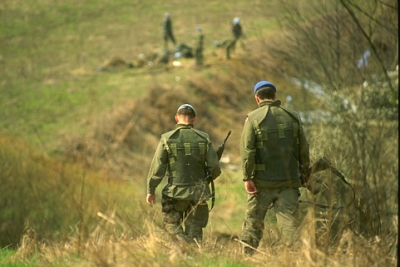

In [12]:
img_dir = '/home/cx95/palmer_scratch/tokencut/datasets/ECSSD/img'
img_name = '0025.jpg'
img_path = os.path.join(img_dir, img_name)
img_path
Image.open(img_path).convert('RGB')

In [108]:
bipartitions, eigvecs, I_new=maskcut(img_path, backbone, patch_size, tau=0.01, N=2)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0',
       dtype=torch.float64)


In [13]:
feat,w, h, feat_w, feat_h = get_tokencut_binary_map(img_path, backbone, patch_size, attn='self')

In [99]:
width, height = I.size
p_masks = []
for idx, bipartition in enumerate(bipartitions):
    # post-process pesudo-masks with CRF
    pseudo_mask = densecrf(np.array(I_new), bipartition)
    pseudo_mask = ndimage.binary_fill_holes(pseudo_mask>=0.5)

    # filter out the mask that have a very different pseudo-mask after the CRF
    mask1 = torch.from_numpy(bipartition)
    mask2 = torch.from_numpy(pseudo_mask)
    mask1 = mask1.cuda()
    mask2 = mask2.cuda()
    if metric.IoU(mask1, mask2) < 0.5:
        pseudo_mask = pseudo_mask * -1

    # construct binary pseudo-masks
    pseudo_mask[pseudo_mask < 0] = 0
    pseudo_mask = Image.fromarray(np.uint8(pseudo_mask*255))
    p_masks.append(pseudo_mask)
    # pseudo_mask = np.asarray(pseudo_mask.resize((width, height)))

    # # create coco-style image info
    # image_info = create_image_info(
    #     1, "{}/{}".format('folder', img_name), (height, width, 3))
    # output["images"].append(image_info)         

    # # create coco-style annotation info
    # annotation_info = create_annotation_info(
    #     segmentation_id, image_id, category_info, pseudo_mask.astype(np.uint8), None)
    # if annotation_info is not None:
    #     output["annotations"].append(annotation_info)
    #     segmentation_id += 1


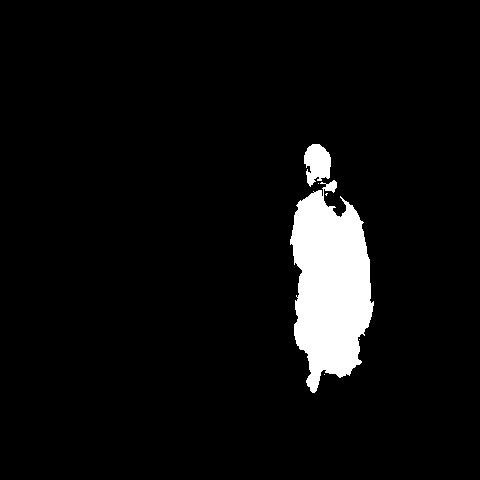

In [106]:
p_masks[0]

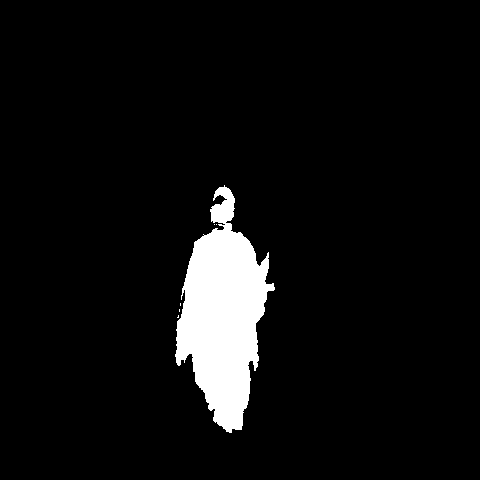

In [105]:
p_masks[1]